# Carbon Intensity Forecasting with LSTM

## Packages and data loading

In [14]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("../Data/BE_C0220150101_20230116.csv")
# df = df[5::24] take values every 24 hours
df["Unnamed: 0"] = df.apply(lambda x: x["Unnamed: 0"][:-6], axis=1)
df.rename(columns={"Unnamed: 0": "Datetime"}, inplace=True)
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df

,Biomass,Lignite,Gas,Coal,Oil,Geothermal,Hydro_storage,Hydro,Hydro_res,Nuclear,Other,Other_renew,Solar,Waste,Wind_off,Wind_on,Total,Carbon Intensity
Datetime,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,15.64,0.0,1526.672,480.240,0.0,0.0,287.765,0.396,0.0,14.375,412.3,0.0,0.000,186.9,6.591,2.301,2933.180,374.847284
2015-01-01 01:00:00,15.87,0.0,1510.418,479.136,0.0,0.0,131.427,0.396,0.0,14.375,466.2,0.0,0.000,188.3,6.383,2.665,2815.170,365.274426
2015-01-01 02:00:00,15.87,0.0,1482.726,480.240,0.0,0.0,0.000,0.396,0.0,14.370,463.4,0.0,0.000,189.7,6.747,2.808,2656.257,352.055268
2015-01-01 03:00:00,15.64,0.0,1350.286,481.344,0.0,0.0,0.000,0.396,0.0,14.365,444.5,0.0,0.000,186.2,6.877,3.081,2502.689,341.757340
2015-01-01 04:00:00,15.41,0.0,1284.668,481.344,0.0,0.0,0.000,0.407,0.0,14.370,417.9,0.0,0.000,187.6,5.291,4.238,2411.228,337.423454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 10:00:00,27.83,0.0,248.024,0.000,0.0,0.0,0.000,0.066,0.0,24.505,0.0,0.0,26.425,72.8,26.338,27.859,453.847,43.355655
2023-01-15 11:00:00,27.37,0.0,245.014,0.000,0.0,0.0,235.366,0.077,0.0,24.505,0.0,0.0,38.045,74.2,26.533,28.496,699.606,62.835100
2023-01-15 12:00:00,27.60,0.0,244.412,0.000,0.0,0.0,0.000,0.077,0.0,24.545,0.0,0.0,37.835,74.9,25.792,29.042,464.203,42.791574


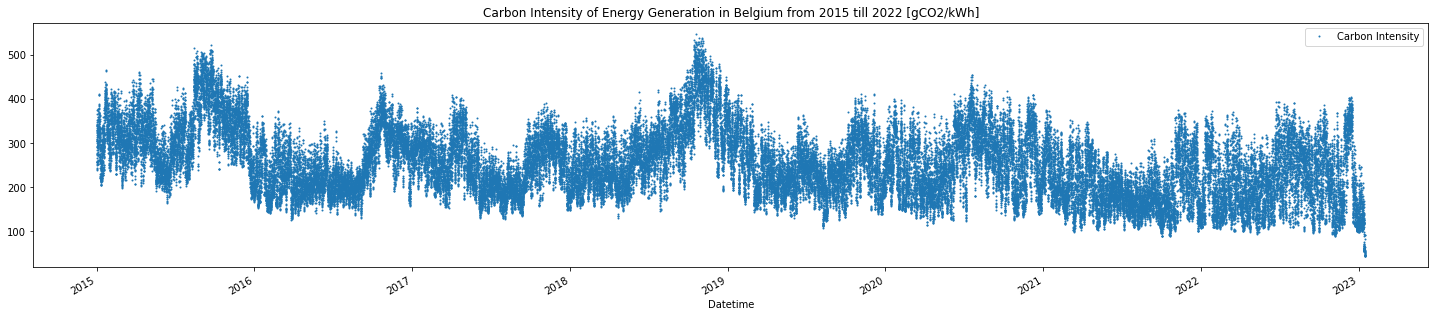

In [3]:
# Carbon Emission Intensity (CEI)
cei = df["Carbon Intensity"]
cei.plot(
    style=".",
    figsize=(25, 5),
    ms=2,
    title="Carbon Intensity of Energy Generation in Belgium from 2015 till 2022 [gCO2/kWh]",
    legend=["gCO2/kWh"],
)
plt.show()

## Goal:
- Every last 5 hours try to predict CEI for next hour

In [4]:
# [[[1],[2],[3],[4],[5]]] [6]
# [[[2],[3],[4],[5], [6]]] [7]

In [5]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i : i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [6]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(cei, WINDOW_SIZE)
X1.shape, y1.shape

((70474, 5, 1), (70474,))

In [7]:
X_train1, y_train1 = X1[:60000], y1[:60000]
X_val1, y_val1 = X1[60000:65000], y1[60000:65000]
X_test1, y_test1 = X1[65000:], y1[65000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5474, 5, 1), (5474,))

In [8]:


model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

2023-01-16 23:08:27.722402: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-16 23:08:27.722530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [9]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [10]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10


2023-01-16 23:08:28.016866: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-16 23:08:28.559039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-16 23:08:28.642795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   7/1875 [..............................] - ETA: 16s - loss: 72389.2188 - root_mean_squared_error: 269.0525  

2023-01-16 23:08:28.760959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1873/1875 [============================>.] - ETA: 0s - loss: 15191.3027 - root_mean_squared_error: 123.2530

2023-01-16 23:08:43.322216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-16 23:08:43.367452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 20s 10ms/step - loss: 15175.6982 - root_mean_squared_error: 123.1897 - val_loss: 337.3817 - val_root_mean_squared_error: 18.3680
Epoch 2/10
1869/1875 [============================>.] - ETA: 0s - loss: 316.2544 - root_mean_squared_error: 17.7835

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 18s 10ms/step - loss: 315.9671 - root_mean_squared_error: 17.7755 - val_loss: 308.4838 - val_root_mean_squared_error: 17.5637
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 249.5830 - root_mean_squared_error: 15.7982

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 18s 10ms/step - loss: 249.5840 - root_mean_squared_error: 15.7982 - val_loss: 298.2301 - val_root_mean_squared_error: 17.2693
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 239.3933 - root_mean_squared_error: 15.4723 - val_loss: 306.2992 - val_root_mean_squared_error: 17.5014
Epoch 5/10
1871/1875 [============================>.] - ETA: 0s - loss: 239.2020 - root_mean_squared_error: 15.4662

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1875/1875 [==============================] - 22s 12ms/step - loss: 239.0985 - root_mean_squared_error: 15.4628 - val_loss: 292.2383 - val_root_mean_squared_error: 17.0950
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 238.8279 - root_mean_squared_error: 15.4541 - val_loss: 308.0467 - val_root_mean_squared_error: 17.5513
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 238.5596 - root_mean_squared_error: 15.4454 - val_loss: 301.5005 - val_root_mean_squared_error: 17.3638
Epoch 8/10
1875/1875 [==============================] - 16s 8ms/step - loss: 237.9110 - root_mean_squared_error: 15.4244 - val_loss: 302.5380 - val_root_mean_squared_error: 17.3936
Epoch 9/10
1875/1875 [==============================] - 16s 8ms/step - loss: 235.5839 - root_mean_squared_error: 15.3487 - val_loss: 302.0325 - val_root_mean_squared_error: 17.3791
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - loss: 234.4529 - root_mean_square

In [11]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [13]:
train_predictions = model1.predict(X_train1).flatten()
train_results  = pd.DataFrame(data = {"Train Prediction": train_predictions, 'Actuals': y_train1})
train_results

  14/1875 [..............................] - ETA: 7s  

2023-01-16 23:13:56.624838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-16 23:13:56.666526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 6s 3ms/step


,Train Prediction,Actuals
0,332.157440,338.820792
1,336.770905,329.920773
2,321.284637,323.362881
3,316.378906,313.173764
4,304.489319,292.760369
...,...,...
59995,227.499664,212.461218
59996,205.773560,211.088725
59997,211.380127,224.440633
59998,231.714233,223.544287


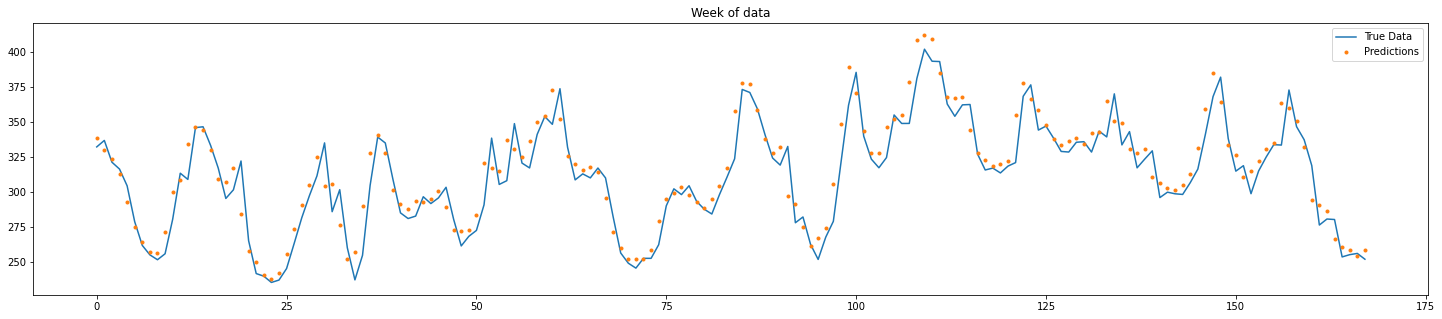

In [20]:
ax = train_results["Train Prediction"][:7*24].plot(
    figsize=(25, 5),
    title="Week of data",
)
train_results["Actuals"][:7*24].plot(
    style="."
)
plt.legend(["True Data", "Predictions"])
plt.show()

In [18]:
val_predictions = model1.predict(X_val1).flatten()
val_results  = pd.DataFrame(data = {"Val Prediction": val_predictions, 'Actuals': y_val1})
val_results

157/157 [==============================] - 1s 3ms/step


,Val Prediction,Actuals
0,231.203812,248.596687
1,258.067627,287.715476
2,298.077759,290.390680
3,279.561829,277.433043
4,264.664856,274.305847
...,...,...
4995,201.640015,199.608679
4996,194.190399,195.684440
4997,194.308258,187.930204
4998,185.713898,180.097104


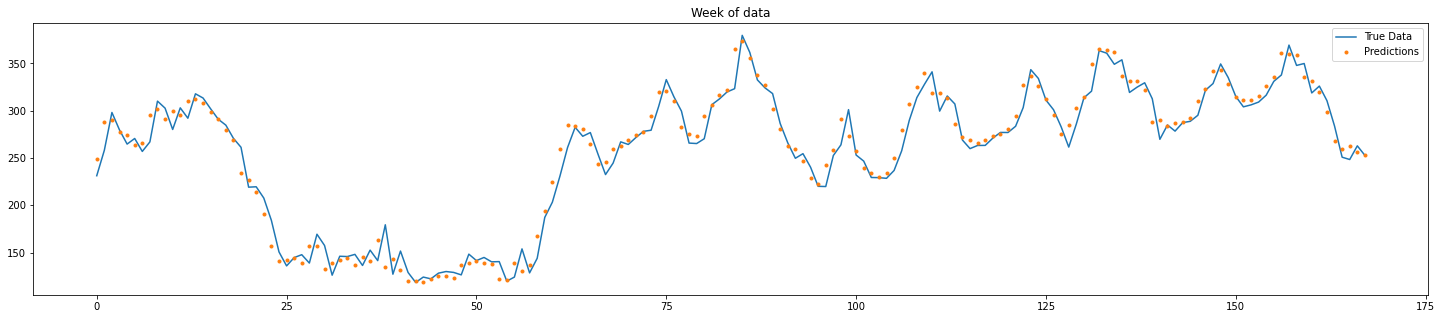

In [22]:
ax = val_results["Val Prediction"][:7*24].plot(
    figsize=(25, 5),
    title="Week of data",
)
val_results["Actuals"][:7*24].plot(
    style="."
)
plt.legend(["True Data", "Predictions"])
plt.show()

In [23]:
test_predictions = model1.predict(X_test1).flatten()
test_results  = pd.DataFrame(data = {"Test Prediction": test_predictions, 'Actuals': y_test1})
test_results

172/172 [==============================] - 1s 4ms/step


,Test Prediction,Actuals
0,184.421341,195.705410
1,202.945892,191.454328
2,188.166687,181.059453
3,177.128143,186.816352
4,190.651520,202.343294
...,...,...
5469,53.650776,43.355655
5470,45.452190,62.835100
5471,79.825371,42.791574
5472,38.980770,43.464618


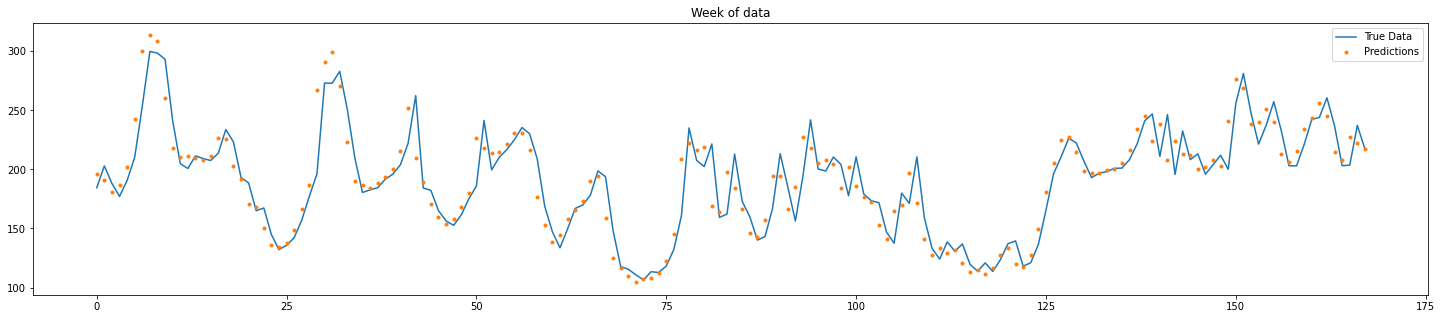

In [24]:
ax = test_results["Test Prediction"][:7*24].plot(
    figsize=(25, 5),
    title="Week of data",
)
test_results["Actuals"][:7*24].plot(
    style="."
)
plt.legend(["True Data", "Predictions"])
plt.show()

In [25]:
df

,Biomass,Lignite,Gas,Coal,Oil,Geothermal,Hydro_storage,Hydro,Hydro_res,Nuclear,Other,Other_renew,Solar,Waste,Wind_off,Wind_on,Total,Carbon Intensity
Datetime,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,15.64,0.0,1526.672,480.240,0.0,0.0,287.765,0.396,0.0,14.375,412.3,0.0,0.000,186.9,6.591,2.301,2933.180,374.847284
2015-01-01 01:00:00,15.87,0.0,1510.418,479.136,0.0,0.0,131.427,0.396,0.0,14.375,466.2,0.0,0.000,188.3,6.383,2.665,2815.170,365.274426
2015-01-01 02:00:00,15.87,0.0,1482.726,480.240,0.0,0.0,0.000,0.396,0.0,14.370,463.4,0.0,0.000,189.7,6.747,2.808,2656.257,352.055268
2015-01-01 03:00:00,15.64,0.0,1350.286,481.344,0.0,0.0,0.000,0.396,0.0,14.365,444.5,0.0,0.000,186.2,6.877,3.081,2502.689,341.757340
2015-01-01 04:00:00,15.41,0.0,1284.668,481.344,0.0,0.0,0.000,0.407,0.0,14.370,417.9,0.0,0.000,187.6,5.291,4.238,2411.228,337.423454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 10:00:00,27.83,0.0,248.024,0.000,0.0,0.0,0.000,0.066,0.0,24.505,0.0,0.0,26.425,72.8,26.338,27.859,453.847,43.355655
2023-01-15 11:00:00,27.37,0.0,245.014,0.000,0.0,0.0,235.366,0.077,0.0,24.505,0.0,0.0,38.045,74.2,26.533,28.496,699.606,62.835100
2023-01-15 12:00:00,27.60,0.0,244.412,0.000,0.0,0.0,0.000,0.077,0.0,24.545,0.0,0.0,37.835,74.9,25.792,29.042,464.203,42.791574


In [33]:
df1 = pd.read_csv("../Data/BE_gen_RAW20230115_20230116.csv", index_col='Datetime', parse_dates = True)

,Biomass,Fossil Gas,Fossil Oil,Hydro Pumped Storage,Hydro Run-of-river and poundage,Nuclear,Solar,Waste,Wind Offshore,Wind Onshore
Datetime,,,,,,,,,,
2023-01-15 00:00:00+01:00,155.0,406.0,0.0,NaN,6.0,4912.0,0.0,95.0,1969.0,1617.0
2023-01-15 01:00:00+01:00,118.0,398.0,0.0,NaN,6.0,4911.0,0.0,98.0,1930.0,1603.0
2023-01-15 02:00:00+01:00,116.0,401.0,0.0,NaN,6.0,4909.0,0.0,97.0,1946.0,1460.0
2023-01-15 03:00:00+01:00,117.0,399.0,0.0,NaN,6.0,4906.0,0.0,101.0,1960.0,1475.0
2023-01-15 04:00:00+01:00,119.0,399.0,0.0,NaN,6.0,4901.0,0.0,104.0,2068.0,1616.0
2023-01-15 05:00:00+01:00,121.0,401.0,0.0,NaN,6.0,4901.0,0.0,108.0,2053.0,1803.0
2023-01-15 06:00:00+01:00,121.0,404.0,0.0,NaN,6.0,4903.0,0.0,107.0,2088.0,1862.0
2023-01-15 07:00:00+01:00,120.0,412.0,0.0,77.0,6.0,4902.0,0.0,107.0,2099.0,1975.0
2023-01-15 08:00:00+01:00,119.0,412.0,0.0,26.0,6.0,4901.0,1.0,105.0,2106.0,1997.0


In [35]:
df1.index

DatetimeIndex(['2023-01-15 00:00:00+01:00', '2023-01-15 01:00:00+01:00',
               '2023-01-15 02:00:00+01:00', '2023-01-15 03:00:00+01:00',
               '2023-01-15 04:00:00+01:00', '2023-01-15 05:00:00+01:00',
               '2023-01-15 06:00:00+01:00', '2023-01-15 07:00:00+01:00',
               '2023-01-15 08:00:00+01:00', '2023-01-15 09:00:00+01:00',
               '2023-01-15 10:00:00+01:00', '2023-01-15 11:00:00+01:00',
               '2023-01-15 12:00:00+01:00', '2023-01-15 13:00:00+01:00',
               '2023-01-15 14:00:00+01:00', '2023-01-15 15:00:00+01:00',
               '2023-01-15 16:00:00+01:00', '2023-01-15 17:00:00+01:00',
               '2023-01-15 18:00:00+01:00', '2023-01-15 19:00:00+01:00',
               '2023-01-15 20:00:00+01:00', '2023-01-15 21:00:00+01:00',
               '2023-01-15 22:00:00+01:00', '2023-01-15 23:00:00+01:00'],
              dtype='datetime64[ns, pytz.FixedOffset(60)]', name='Datetime', freq=None)

In [30]:
df.index 

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2023-01-15 05:00:00', '2023-01-15 06:00:00',
               '2023-01-15 07:00:00', '2023-01-15 08:00:00',
               '2023-01-15 09:00:00', '2023-01-15 10:00:00',
               '2023-01-15 11:00:00', '2023-01-15 12:00:00',
               '2023-01-15 13:00:00', '2023-01-15 14:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=70479, freq=None)

In [31]:
df

,Biomass,Lignite,Gas,Coal,Oil,Geothermal,Hydro_storage,Hydro,Hydro_res,Nuclear,Other,Other_renew,Solar,Waste,Wind_off,Wind_on,Total,Carbon Intensity
Datetime,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,15.64,0.0,1526.672,480.240,0.0,0.0,287.765,0.396,0.0,14.375,412.3,0.0,0.000,186.9,6.591,2.301,2933.180,374.847284
2015-01-01 01:00:00,15.87,0.0,1510.418,479.136,0.0,0.0,131.427,0.396,0.0,14.375,466.2,0.0,0.000,188.3,6.383,2.665,2815.170,365.274426
2015-01-01 02:00:00,15.87,0.0,1482.726,480.240,0.0,0.0,0.000,0.396,0.0,14.370,463.4,0.0,0.000,189.7,6.747,2.808,2656.257,352.055268
2015-01-01 03:00:00,15.64,0.0,1350.286,481.344,0.0,0.0,0.000,0.396,0.0,14.365,444.5,0.0,0.000,186.2,6.877,3.081,2502.689,341.757340
2015-01-01 04:00:00,15.41,0.0,1284.668,481.344,0.0,0.0,0.000,0.407,0.0,14.370,417.9,0.0,0.000,187.6,5.291,4.238,2411.228,337.423454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 10:00:00,27.83,0.0,248.024,0.000,0.0,0.0,0.000,0.066,0.0,24.505,0.0,0.0,26.425,72.8,26.338,27.859,453.847,43.355655
2023-01-15 11:00:00,27.37,0.0,245.014,0.000,0.0,0.0,235.366,0.077,0.0,24.505,0.0,0.0,38.045,74.2,26.533,28.496,699.606,62.835100
2023-01-15 12:00:00,27.60,0.0,244.412,0.000,0.0,0.0,0.000,0.077,0.0,24.545,0.0,0.0,37.835,74.9,25.792,29.042,464.203,42.791574
